## Install Fenics

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2022-08-09 18:44:16--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-08-09 18:44:16 (23.9 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

## Coupled Cahn Hilliard Equation

### The First Example

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 18 22:23:19 2020

@author: bilginkocak
"""

import random
from dolfin import *
import numpy as np

class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        values[0] = np.sin(10*x[0]*x[1])
        values[1] = 0.0
        values[2] = np.cos(10*(x[0]-x[1]))*x[0]*x[1]
        values[3] = 0.0
    def value_shape(self):
        return (4,)

class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Create mesh and build function space
mesh = UnitSquareMesh.create(30, 30, CellType.Type.triangle)
#mesh = UnitSquareMesh(20,20)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
TH = MixedElement([P1, P1, P1, P1])
ME = FunctionSpace(mesh, TH)

dt     = 1.0e-4  # time step
epsv = 0.05
epsu = 0.05
beta = 0.1
sigma = 100
tu = 1
tv = 10
beta = -0.9
alpha = 0.04
sigma = 100

# Define trial and test functions
du    = TrialFunction(ME)
q1, q2, q3, q4  = TestFunctions(ME)

# Define functions
uu   = Function(ME)  # current solution
uu0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dc1, dmu1, dc2, dmu2 = split(du)
c1,  mu1, c2, mu2  = split(uu)
c10, mu10, c20, mu20 = split(uu0)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=2)
uu.interpolate(u_init)
uu0.interpolate(u_init)

f1 = (1-c1)*(1+c1)*c1 - alpha*c2 - beta*c2**2
f2 = (1-c2)*(1+c2)*c2 - alpha*c2 - 2*beta*c1*c2
vbar = assemble(uu.split()[2]*dx)
# vbar = 0.0114559
L0 = c1*q1*dx - c10*q1*dx - dt*dot(grad(mu1),grad(q1))*dx
L1 = mu1*q2*dx + epsu**2*dot(grad(c1),grad(q2))*dx - f1*q2*dx
L2 = c2*q3*dx - c20*q3*dx - dt*dot(grad(mu2),grad(q3))*dx + dt*sigma*(c2-vbar)*q3*dx
L3 = mu2*q4*dx + epsv**2*dot(grad(c2),grad(q4))*dx - f2*q4*dx
L = L0 + L1 + L2 + L3

# Compute directional derivative about u in the direction of du (Jacobian)
a = derivative(L, uu, du)

# Create nonlinear problem and Newton solver
problem = CahnHilliardEquation(a, L)
solver = NewtonSolver()
solver.parameters["linear_solver"] = "lu"
solver.parameters["convergence_criterion"] = "incremental"
solver.parameters["relative_tolerance"] = 1e-6

# Output file
file = File("2n/output.pvd", "compressed")
file2 = File("2n/output_v.pvd", "compressed")
#file3 = File("2n/output_mu1.pvd", "compressed")
#file4 = File("2n/output_mu2.pvd", "compressed")

# Step in time
t = 0.0
T = 1000*dt
while (t < T):
    t += dt
    file << (uu.split()[0], t)
    file2 << (uu.split()[2], t)
    #file3 << (uu.split()[1], t)
    #file4 << (uu.split()[3], t)
    uu0.vector()[:] = uu.vector()
    solver.solve(problem, uu.vector())
    

#%%

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


### Onion Shape Example

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 18 22:23:19 2020

@author: bilginkocak
"""

import random
from dolfin import *
import numpy as np

class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        if (x[0]-0.5)**2 + (x[1]-0.5)**2  <= 0.125:
            values[2] = np.sin(15*np.pi*x[0])
        else:
            values[2] = -0.2 #+ 0.2*(0.5 - random.random())
        values[1] = 0.0
        values[3] = 0.0
        if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.125:
            values[0] = 0.6 #+ 0.2*(0.5 - random.random())
        else:
            values[0] = -0.6 #+ 0.2*(0.5 - random.random())
        # values[3] = values[2]
        # values[1] = values[0]
    def value_shape(self):
        return (4,)

class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Create mesh and build function space
mesh = UnitSquareMesh.create(30, 30, CellType.Type.triangle)
#mesh = UnitSquareMesh(20,20)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
TH = MixedElement([P1, P1, P1, P1])
ME = FunctionSpace(mesh, TH)

dt     = 5.0e-4  # time step
epsv = 0.025
epsu = 0.025
tu = 1
tv = 10
beta = -0.8
alpha = 0.3
sigma = 100

# Define trial and test functions
du    = TrialFunction(ME)
q1, q2, q3, q4  = TestFunctions(ME)

# Define functions
uu   = Function(ME)  # current solution
uu0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dc1, dmu1, dc2, dmu2 = split(du)
c1,  mu1, c2, mu2  = split(uu)
c10, mu10, c20, mu20 = split(uu0)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=2)
uu.interpolate(u_init)
uu0.interpolate(u_init)

f1 = (1-c1)*(1+c1)*c1 - alpha*c2 - beta*c2**2
f2 = (1-c2)*(1+c2)*c2 - alpha*c2 - 2*beta*c1*c2
vbar = assemble(uu.split()[2]*dx)
# vbar = 0.0114559
L0 = c1*q1*dx - c10*q1*dx - dt*dot(grad(mu1),grad(q1))*dx
L1 = mu1*q2*dx + epsu**2*dot(grad(c1),grad(q2))*dx - f1*q2*dx
L2 = c2*q3*dx - c20*q3*dx - dt*dot(grad(mu2),grad(q3))*dx + dt*sigma*(c2-vbar)*q3*dx
L3 = mu2*q4*dx + epsv**2*dot(grad(c2),grad(q4))*dx - f2*q4*dx
L = L0 + L1 + L2 + L3

# Compute directional derivative about u in the direction of du (Jacobian)
a = derivative(L, uu, du)

# Create nonlinear problem and Newton solver
problem = CahnHilliardEquation(a, L)
solver = NewtonSolver()
solver.parameters["linear_solver"] = "lu"
solver.parameters["convergence_criterion"] = "incremental"
solver.parameters["relative_tolerance"] = 1e-6

# Output file
file = File("2n/output.pvd", "compressed")
file2 = File("2n/output_v.pvd", "compressed")
#file3 = File("2n/output_mu1.pvd", "compressed")
#file4 = File("2n/output_mu2.pvd", "compressed")

# Step in time
t = 0.0
T = 1e4*dt
while (t < T):
    t += dt
    file << (uu.split()[0], t)
    file2 << (uu.split()[2], t)
    #file3 << (uu.split()[1], t)
    #file4 << (uu.split()[3], t)
    uu0.vector()[:] = uu.vector()
    solver.solve(problem, uu.vector())
    

#%%

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3070a44bd7b929f83c1138371af9d6b3ab4a3f9b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_15071, f_15074]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?), CG1(?,?), CG1(?,?)>, Vector<
                             2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?), CG1(?,?), CG1(?,?)>, Vector<
                             2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:F

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_66bf3582d894428501b98943f798cc65c1f85ce2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_15071]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?), CG1(?,?), CG1(?,?)>, Vector<
                             2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?), CG1(?,?), CG1(?,?)>, Vector<
                             2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:C

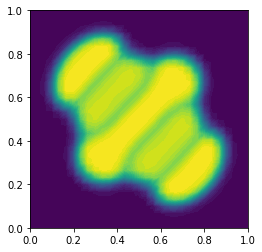

In [ ]:
plot(uu.split()[0])

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 18 22:23:19 2020

@author: bilginkocak
"""

import random
from dolfin import *
import numpy as np

class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        # values[0] = 0.63 + 0.02*(0.5 - random.random())
        # if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.1:
        #     values[0] = np.sin(10*np.pi*x[0])
        # else:
        #     values[0] = -0.99
        if (x[0]-0.5)**2 + (x[1]-0.5)**2  <= 0.125:
            values[2] = np.sin(15*np.pi*x[0])
        else:
            values[2] = -0.2 #+ 0.2*(0.5 - random.random())
        # values[0] = np.sin(10*x[0]*x[1])
        values[1] = 0.0
        # values[2] = np.cos(10*(x[0]-x[1]))*x[0]*x[1]
        # if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.1:
        #     np.cos(10*(x[0]-x[1]))*x[0]*x[1]
        # else:
        #     values[2] = -0.99
        if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.125:
            # values[0] = np.cos(10*(x[0]-x[1]))*x[0]*x[1]
            values[0] = 0.6 #+ 0.2*(0.5 - random.random())
        else:
            values[0] = -0.6 #+ 0.2*(0.5 - random.random())
        values[3] = values[2]
        values[1] = values[0]
        # values[0] = 0.0 + 2*(0.5 - random.random())
        # values[1] = 0.0
        # values[2] = 0.0 + 2*(0.5 - random.random())
        # values[3] = 0.0
    def value_shape(self):
        return (4,)

class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Create mesh and build function space
mesh = UnitSquareMesh.create(30, 30, CellType.Type.triangle)
#mesh = UnitSquareMesh(20,20)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
TH = MixedElement([P1, P1, P1, P1])
ME = FunctionSpace(mesh, TH)

dt     = 5.0e-4  # time step
epsv = 0.025
epsu = 0.05
#alpha = 0.04
beta = 0.1
sigma = 100
tu = 1
tv = 100
beta = -0.15
alpha = 0.4
tv = 100
sigma = 500

# Define trial and test functions
du    = TrialFunction(ME)
q1, q2, q3, q4  = TestFunctions(ME)

# Define functions
uu   = Function(ME)  # current solution
uu0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dc1, dmu1, dc2, dmu2 = split(du)
c1,  mu1, c2, mu2  = split(uu)
c10, mu10, c20, mu20 = split(uu0)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=2)
uu.interpolate(u_init)
uu0.interpolate(u_init)

f1 = (1-c1)*(1+c1)*c1 - alpha*c2 - beta*c2**2
f2 = (1-c2)*(1+c2)*c2 - alpha*c2 - 2*beta*c1*c2
vbar = assemble(uu.split()[2]*dx)
# vbar = 0.0114559
L0 = c1*q1*dx - c10*q1*dx - dt*dot(grad(mu1),grad(q1))*dx
L1 = mu1*q2*dx + epsu**2*dot(grad(c1),grad(q2))*dx - f1*q2*dx
L2 = c2*q3*dx - c20*q3*dx - dt*dot(grad(mu2),grad(q3))*dx + dt*sigma*(c2-vbar)*q3*dx
L3 = mu2*q4*dx + epsv**2*dot(grad(c2),grad(q4))*dx - f2*q4*dx
L = L0 + L1 + L2 + L3

# Compute directional derivative about u in the direction of du (Jacobian)
a = derivative(L, uu, du)

# Create nonlinear problem and Newton solver
problem = CahnHilliardEquation(a, L)
solver = NewtonSolver()
solver.parameters["linear_solver"] = "lu"
solver.parameters["convergence_criterion"] = "incremental"
solver.parameters["relative_tolerance"] = 1e-6

# Output file
file = File("2n/output.pvd", "compressed")
file2 = File("2n/output_v.pvd", "compressed")
#file3 = File("2n/output_mu1.pvd", "compressed")
#file4 = File("2n/output_mu2.pvd", "compressed")

# Step in time
t = 0.0
# T = 1000*dt
T = 200*dt
while (t < T):
    t += dt
    file << (uu.split()[0], t)
    file2 << (uu.split()[2], t)
    #file3 << (uu.split()[1], t)
    #file4 << (uu.split()[3], t)
    uu0.vector()[:] = uu.vector()
    solver.solve(problem, uu.vector())
    

#%%

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


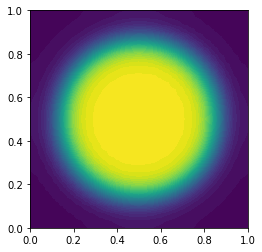

In [ ]:
plot(c1)

Calling FFC just-in-time (JIT) compiler, this may take some time.


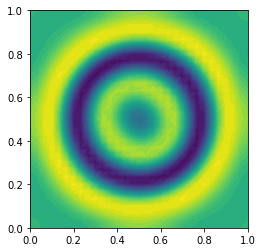

In [ ]:
plot(c2)

In [ ]:
!zip -r /content/file.zip /content/2n

updating: content/2n/ (stored 0%)
updating: content/2n/output_v000029.vtu (deflated 85%)
updating: content/2n/output_v000298.vtu (deflated 85%)
updating: content/2n/output000299.vtu (deflated 85%)
updating: content/2n/output_v000007.vtu (deflated 85%)
updating: content/2n/output_v000190.vtu (deflated 85%)
updating: content/2n/output000278.vtu (deflated 85%)
updating: content/2n/output_v000272.vtu (deflated 85%)
updating: content/2n/output000230.vtu (deflated 85%)
updating: content/2n/output000280.vtu (deflated 85%)
updating: content/2n/output_v000021.vtu (deflated 85%)
updating: content/2n/output000097.vtu (deflated 85%)
updating: content/2n/output_v000044.vtu (deflated 85%)
updating: content/2n/output_v000036.vtu (deflated 85%)
updating: content/2n/output000052.vtu (deflated 85%)
updating: content/2n/output000078.vtu (deflated 85%)
updating: content/2n/output000034.vtu (deflated 85%)
updating: content/2n/output_v000107.vtu (deflated 85%)
updating: content/2n/output000134.vtu (deflated

## Searching Different Shapes

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 18 22:23:19 2020
 surface enerji termünde değişiklik yapıldı.
@author: bilginkocak
"""

import random
from dolfin import *
import numpy as np

class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        # values[0] = 0.63 + 0.02*(0.5 - random.random())
        # if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.1:
        #     values[0] = np.sin(10*np.pi*x[0])
        # else:
        #     values[0] = -0.99
        if (x[0]-0.5)**2 + (x[1]-0.5)**2  <= 0.125:
            values[2] = np.sin(15*np.pi*x[0])
        else:
            values[2] = -0.2 #+ 0.2*(0.5 - random.random())
        # values[0] = np.sin(10*x[0]*x[1])
        values[1] = 0.0
        # values[2] = np.cos(10*(x[0]-x[1]))*x[0]*x[1]
        # if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.1:
        #     np.cos(10*(x[0]-x[1]))*x[0]*x[1]
        # else:
        #     values[2] = -0.99
        if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.125:
            # values[0] = np.cos(10*(x[0]-x[1]))*x[0]*x[1]
            values[0] = 0.6 #+ 0.2*(0.5 - random.random())
        else:
            values[0] = -0.6 #+ 0.2*(0.5 - random.random())
        values[3] = values[2]
        values[1] = values[0]
        # values[0] = 0.0 + 2*(0.5 - random.random())
        # values[1] = 0.0
        # values[2] = 0.0 + 2*(0.5 - random.random())
        # values[3] = 0.0
    def value_shape(self):
        return (4,)

class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Create mesh and build function space
mesh = UnitSquareMesh.create(40, 40, CellType.Type.triangle)
#mesh = UnitSquareMesh(20,20)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
TH = MixedElement([P1, P1, P1, P1])
ME = FunctionSpace(mesh, TH)

dt     = 5.0e-4  # time step
epsv = 0.025
epsu = 0.05
#alpha = 0.04
beta = 0.1
tu = 1
tv = 100
beta = -0.15
alpha = 0.4
tv = 100
sigma = 500
def getSolution(epsv,epsu,beta,alpha,sigma):
  # Define trial and test functions
  du    = TrialFunction(ME)
  q1, q2, q3, q4  = TestFunctions(ME)

  # Define functions
  uu   = Function(ME)  # current solution
  uu0  = Function(ME)  # solution from previous converged step

  # Split mixed functions
  dc1, dmu1, dc2, dmu2 = split(du)
  c1,  mu1, c2, mu2  = split(uu)
  c10, mu10, c20, mu20 = split(uu0)

  # Create intial conditions and interpolate
  u_init = InitialConditions(degree=2)
  uu.interpolate(u_init)
  uu0.interpolate(u_init)

  f1 = (1-c1)*(1+c1)*c1 - alpha*c2 - beta*c2**2
  f2 = (1-c2)*(1+c2)*c2 - alpha*c1 - 2*beta*c1*c2
  vbar = assemble(uu.split()[2]*dx)
  # vbar = 0.0114559
  L0 = c1*q1*dx - c10*q1*dx - dt*dot(grad(mu1),grad(q1))*dx
  L1 = mu1*q2*dx + epsu**2*dot(grad(c1),grad(q2))*dx - f1*q2*dx
  L2 = c2*q3*dx - c20*q3*dx - dt*dot(grad(mu2),grad(q3))*dx + dt*sigma*(c2-vbar)*q3*dx
  L3 = mu2*q4*dx + epsv**2*dot(grad(c2),grad(q4))*dx - f2*q4*dx
  L = L0 + L1 + L2 + L3

  # Compute directional derivative about u in the direction of du (Jacobian)
  a = derivative(L, uu, du)

  # Create nonlinear problem and Newton solver
  problem = CahnHilliardEquation(a, L)
  solver = NewtonSolver()
  solver.parameters["linear_solver"] = "lu"
  solver.parameters["convergence_criterion"] = "incremental"
  solver.parameters["relative_tolerance"] = 1e-6

  # Output file
  #file = File("2n/output.pvd", "compressed")
  #file2 = File("2n/output_v.pvd", "compressed")
  #file3 = File("2n/output_mu1.pvd", "compressed")
  #file4 = File("2n/output_mu2.pvd", "compressed")

  # Step in time
  t = 0.0
  # T = 1000*dt
  T = 300*dt
  while (t < T):
      t += dt
      #file << (uu.split()[0], t)
      #file2 << (uu.split()[2], t)
      #file3 << (uu.split()[1], t)
      #file4 << (uu.split()[3], t)
      uu0.vector()[:] = uu.vector()
      solver.solve(problem, uu.vector())
      
  return uu.split()[0], uu.split()[2]
  #%%

In [ ]:
epsvs = [0.009]
epsus = [0.02]
betas = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1.0 ]
alphas = [0.1,0.2,0.3]
sigmas = [1000]
#sigmas = [500]
results = {}

for epsv in epsvs:
  for epsu in epsus:
    for beta in betas:
      for alpha in alphas:
        for sigma in sigmas:
          _c1,_c2 = getSolution(epsv,epsu,beta,alpha,sigma)
          results[str(epsv)+"_"+str(epsu)+"_"+str(beta)+"_"+str(alpha)+"_"+str(sigma)] = (_c1, _c2)
          print("Done : "+str(epsv)+"_"+str(epsu)+"_"+str(beta)+"_"+str(alpha)+"_"+str(sigma))


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done : 0.009_0.02_-0.1_0.1_1000
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done : 0.009_0.02_-0.1_0.2_1000
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done : 0.009_0.02_-0.1_0.3_1000
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done : 0.009_0.02_-0.2_0.1_1000
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done : 0.009_0.02_-0.2_0.2_1000
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done : 0.009_0.02_-0.2_0.3_1000
Calling FFC just

RuntimeError: ignored

In [ ]:
key = list(results.keys())[0]
results[key]

(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 3), FiniteElement('Lagrange', triangle, 1)), 2623),
 Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 3), FiniteElement('Lagrange', triangle, 1)), 2629))

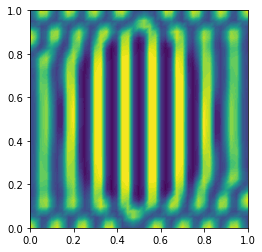

In [ ]:
plot(results[key][1])

In [ ]:
for key in results.keys():
  #file1 = File("n/"+key+"_u.pvd","compressed")
  file2 = File("alpha:0.3/"+key+"_v.pvd","compressed")
  #file1 << results[key][0]
  file2 << results[key][1]

In [ ]:
!zip -r /content/file.zip /content/alpha:0.3

  adding: content/alpha:0.3/ (stored 0%)
  adding: content/alpha:0.3/0.009_0.02_-0.5_0.3_1000_v000000.vtu (deflated 86%)
  adding: content/alpha:0.3/0.009_0.02_-0.2_0.3_1000_v.pvd (deflated 27%)
  adding: content/alpha:0.3/0.009_0.02_-0.6_0.3_1000_v.pvd (deflated 27%)
  adding: content/alpha:0.3/0.009_0.02_-0.3_0.1_1000_v000000.vtu (deflated 86%)
  adding: content/alpha:0.3/0.009_0.02_-0.2_0.1_1000_v.pvd (deflated 28%)
  adding: content/alpha:0.3/0.009_0.02_-0.6_0.1_1000_v000000.vtu (deflated 86%)
  adding: content/alpha:0.3/0.009_0.02_-0.3_0.1_1000_v.pvd (deflated 27%)
  adding: content/alpha:0.3/0.009_0.02_-0.5_0.3_1000_v.pvd (deflated 27%)
  adding: content/alpha:0.3/0.009_0.02_-0.8_0.3_1000_v000000.vtu (deflated 86%)
  adding: content/alpha:0.3/0.009_0.02_-0.7_0.3_1000_v.pvd (deflated 27%)
  adding: content/alpha:0.3/0.009_0.02_-0.4_0.3_1000_v.pvd (deflated 27%)
  adding: content/alpha:0.3/0.009_0.02_-0.6_0.2_1000_v.pvd (deflated 27%)
  adding: content/alpha:0.3/0.009_0.02_-0.1_0.1

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


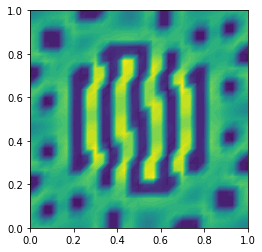

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 18 22:23:19 2020

@author: bilginkocak
"""

import random
from dolfin import *
import numpy as np

class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        # values[0] = 0.63 + 0.02*(0.5 - random.random())
        # if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.1:
        #     values[0] = np.sin(10*np.pi*x[0])
        # else:
        #     values[0] = -0.99
        if (x[0]-0.5)**2 + (x[1]-0.5)**2  <= 0.125:
            values[2] = np.sin(15*np.pi*x[0])
        else:
            values[2] = -0.2 #+ 0.2*(0.5 - random.random())
        # values[0] = np.sin(10*x[0]*x[1])
        values[1] = 0.0
        # values[2] = np.cos(10*(x[0]-x[1]))*x[0]*x[1]
        # if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.1:
        #     np.cos(10*(x[0]-x[1]))*x[0]*x[1]
        # else:
        #     values[2] = -0.99
        if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.125:
            # values[0] = np.cos(10*(x[0]-x[1]))*x[0]*x[1]
            values[0] = 0.6 #+ 0.2*(0.5 - random.random())
        else:
            values[0] = -0.6 #+ 0.2*(0.5 - random.random())
        values[3] = values[2]
        values[1] = values[0]
        # values[0] = 0.0 + 2*(0.5 - random.random())
        # values[1] = 0.0
        # values[2] = 0.0 + 2*(0.5 - random.random())
        # values[3] = 0.0
    def value_shape(self):
        return (4,)

class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Create mesh and build function space
mesh = UnitSquareMesh.create(30, 30, CellType.Type.triangle)
#mesh = UnitSquareMesh(20,20)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
TH = MixedElement([P1, P1, P1, P1])
ME = FunctionSpace(mesh, TH)

dt     = 5.0e-4  # time step
epsv = 0.009
epsu = 0.01
tu = 1
tv = 100
#beta = -0.6
#alpha = 0.5
#sigma = 300
beta = -0.4
alpha = 0.3
sigma = 500


# Define trial and test functions
du    = TrialFunction(ME)
q1, q2, q3, q4  = TestFunctions(ME)

# Define functions
uu   = Function(ME)  # current solution
uu0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dc1, dmu1, dc2, dmu2 = split(du)
c1,  mu1, c2, mu2  = split(uu)
c10, mu10, c20, mu20 = split(uu0)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=2)
uu.interpolate(u_init)
uu0.interpolate(u_init)

f1 = (1-c1)*(1+c1)*c1 - alpha*c2 - beta*c2**2
f2 = (1-c2)*(1+c2)*c2 - alpha*c1 - 2*beta*c1*c2
vbar = assemble(uu.split()[2]*dx)
# vbar = 0.0114559
L0 = c1*q1*dx - c10*q1*dx - dt*dot(grad(mu1),grad(q1))*dx
L1 = mu1*q2*dx + epsu**2*dot(grad(c1),grad(q2))*dx - f1*q2*dx
L2 = c2*q3*dx - c20*q3*dx - dt*dot(grad(mu2),grad(q3))*dx + dt*sigma*(c2-vbar)*q3*dx
L3 = mu2*q4*dx + epsv**2*dot(grad(c2),grad(q4))*dx - f2*q4*dx
L = L0 + L1 + L2 + L3

# Compute directional derivative about u in the direction of du (Jacobian)
a = derivative(L, uu, du)

# Create nonlinear problem and Newton solver
problem = CahnHilliardEquation(a, L)
solver = NewtonSolver()
solver.parameters["linear_solver"] = "lu"
solver.parameters["convergence_criterion"] = "incremental"
solver.parameters["relative_tolerance"] = 1e-6

# Output file
file = File("2n/output.pvd", "compressed")
file2 = File("2n/output_v.pvd", "compressed")
#file3 = File("2n/output_mu1.pvd", "compressed")
#file4 = File("2n/output_mu2.pvd", "compressed")

# Step in time
t = 0.0
# T = 1000*dt
T = 800*dt
count = 0
while (t < T):
    t += dt
    if count%10 == 0:
      file << (uu.split()[0], t)
      file2 << (uu.split()[2], t)
    #file3 << (uu.split()[1], t)
    #file4 << (uu.split()[3], t)
    uu0.vector()[:] = uu.vector()
    solver.solve(problem, uu.vector())
    count += 1
plot(c2)

In [ ]:
!zip -r /content/file.zip /content/2n

  adding: content/2n/ (stored 0%)
  adding: content/2n/output000070.vtu (deflated 85%)
  adding: content/2n/output_v000004.vtu (deflated 84%)
  adding: content/2n/output_v000076.vtu (deflated 85%)
  adding: content/2n/output000076.vtu (deflated 85%)
  adding: content/2n/output000012.vtu (deflated 85%)
  adding: content/2n/output_v000027.vtu (deflated 85%)
  adding: content/2n/output_v000068.vtu (deflated 85%)
  adding: content/2n/output000063.vtu (deflated 85%)
  adding: content/2n/output_v000014.vtu (deflated 85%)
  adding: content/2n/output000034.vtu (deflated 85%)
  adding: content/2n/output000044.vtu (deflated 85%)
  adding: content/2n/output_v000039.vtu (deflated 85%)
  adding: content/2n/output_v000033.vtu (deflated 85%)
  adding: content/2n/output000032.vtu (deflated 85%)
  adding: content/2n/output_v000045.vtu (deflated 85%)
  adding: content/2n/output_v000060.vtu (deflated 85%)
  adding: content/2n/output000037.vtu (deflated 85%)
  adding: content/2n/output000036.vtu (deflated